# FINAL PROJECT : tourism in Europe

### Imports libraries

In [65]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata

## Part 1: tour_dem_ttac : Trips by main mode of accommodation

### 1-1- Eurostat data(tour_dem_ttac) - Cleaning

In [68]:
# 1) Download the dataset

url = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/tour_dem_ttac?lang=EN"

response = requests.get(url, timeout=30)
if response.ok:
    data = response.json()
    print("Root keys:", list(data.keys()))
    print("Dataset label:", data.get("label"))
    print("Updated:", data.get("updated"))
    print("Dimensions (order):", data.get("id"))
    print("Dimension sizes:", data.get("size"))

Root keys: ['version', 'class', 'label', 'source', 'updated', 'value', 'status', 'id', 'size', 'dimension', 'extension']
Dataset label: Trips by main mode of accommodation
Updated: 2025-02-27T23:00:00+0100
Dimensions (order): ['freq', 'c_dest', 'purpose', 'duration', 'accommod', 'unit', 'geo', 'time']
Dimension sizes: [1, 5, 6, 3, 10, 1, 36, 12]


In [69]:
# 2) Build position->code maps for dimensions

dim_ids = data["id"]
sizes   = data["size"]
dims    = data["dimension"]
values  = data["value"]  # sparse dict: {flat_index: value}

idx2code = {}
for d in dim_ids:
    cat = dims[d]["category"]
    idx_map = cat.get("index")
    if isinstance(idx_map, dict):
        idx2code[d] = {idx: code for code, idx in idx_map.items()}
    elif isinstance(idx_map, list):
        idx2code[d] = {i: code for i, code in enumerate(idx_map)}
    else:
        raise ValueError(f"Dimension '{d}' has no usable 'index'.")

def unravel(k, sizes):
    k = int(k); pos = []
    for s in reversed(sizes):
        pos.append(k % s); k //= s
    return list(reversed(pos))

In [70]:
# 3) Decode into a DataFrame

rows = []
for flat_idx, v in values.items():
    pos = unravel(flat_idx, sizes)
    row = {d: idx2code[d][i] for d, i in zip(dim_ids, pos)}
    row["value"] = v
    rows.append(row)
df = pd.DataFrame(rows)

In [71]:
# 4) Minimal filters (ONLY freq, destination, and unit)

df = df[
    (df["freq"] == "A") &        # Annual
    (df["c_dest"] == "WORLD") &  # Whole world
    (df["unit"] == "NR")         # Number
].copy()

df.head(2)

,freq,c_dest,purpose,duration,accommod,unit,geo,time,value
104225,A,WORLD,PER,N1-3,NR_OTH,NR,AL,2017,39885
104226,A,WORLD,PER,N1-3,NR_OTH,NR,AL,2019,7973


In [72]:
# 5) Map labels and build final base columns

geo_labels = dims["geo"]["category"]["label"]
acc_labels = dims["accommod"]["category"]["label"]

df["Country"] = df["geo"].map(geo_labels)
df["Accommodation"] = df["accommod"].map(acc_labels)
df["Time"] = pd.to_numeric(df["time"], errors="coerce").astype("Int64")
df["Value_accomodation"] = pd.to_numeric(df["value"], errors="coerce")

In [73]:
# 6) Aggregate across remaining dims (purpose, duration, etc.)

df_agg = (df
          .groupby(["Country", "Accommodation", "Time"], as_index=False)["Value_accomodation"]
          .sum())

In [116]:
# 7) Exclude totals/aggregates

exclude_accommod = {
    "Total of rented accommodation",
    "Total of non-rented accommodation",
    "Total",
}
exclude_geo = {
    "European Union - 27 countries (from 2020)",
    "Euro area – 20 countries (from 2023)",
    "EFTA (European Free Trade Association countries)",
}

df_agg = df_agg[~df_agg["Accommodation"].isin(exclude_accommod)]
df_agg = df_agg[~df_agg["Country"].isin(exclude_geo)]

df_accomodation = (df_agg
          .sort_values(["Country", "Time", "Accommodation"])
          .reset_index(drop=True))

print("df_accomodation shape:", df_accomodation.shape)
print(df_accomodation.dtypes)
display(df_accomodation.head(12))

df_accomodation shape: (2147, 4)
Country               object
Accommodation         object
Time                   Int64
Value_accomodation     int64
dtype: object


,Country,Accommodation,Time,Value_accomodation
0,Albania,Non-rented accommodation: accommodation provid...,2017,17854125
1,Albania,Non-rented accommodation: other,2017,602359
2,Albania,Non-rented accommodation: own holiday home,2017,939712
3,Albania,"Rented accommodation: campsites, caravan or tr...",2017,314624
4,Albania,Rented accommodation: hotels or similar establ...,2017,4159144
5,Albania,Rented accommodation: other,2017,2530696
6,Albania,Non-rented accommodation: accommodation provid...,2019,20532857
7,Albania,Non-rented accommodation: other,2019,286254
8,Albania,Non-rented accommodation: own holiday home,2019,1140594
9,Albania,"Rented accommodation: campsites, caravan or tr...",2019,74952


In [75]:
#df_accomodation.to_csv('../data/clean/accommodation_eurostat.csv', index=False)

### 1-2- Eurostat data(tour_dem_ttac) - Vizualisations

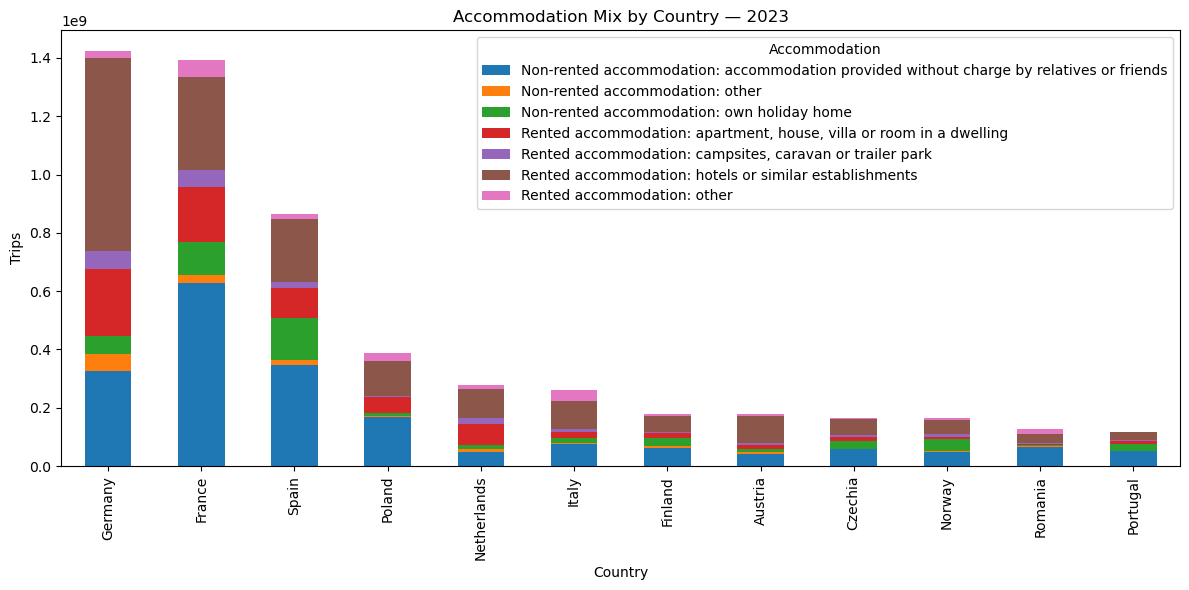

In [77]:
# 1) Accommodation mix by country (latest year, stacked bar)

latest = int(df_accomodation["Time"].max())
mix = (df_accomodation[df_accomodation["Time"] == latest]
       .pivot(index="Country", columns="Accommodation", values="Value_accomodation")
       .fillna(0))

top_n = 12
top_countries = mix.sum(axis=1).sort_values(ascending=False).head(top_n).index
ax = mix.loc[top_countries].plot(kind="bar", stacked=True, figsize=(12,6))
ax.set_title(f"Accommodation Mix by Country — {latest}")
ax.set_xlabel("Country"); ax.set_ylabel("Trips")
plt.tight_layout(); plt.show()

## Part 2: tour_dem_tttr : Trips by Main Mode of transport

### 2-1- Eurostat data(tour_dem_tttr) - Cleaning

In [80]:
# 1) Download & inspect (TTTR)

url_tttr = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/tour_dem_tttr?lang=EN"
r2 = requests.get(url_tttr, timeout=30)
r2.raise_for_status()
data2 = r2.json()

print("TTTR Root keys:", list(data2.keys()))
print("TTTR label:", data2.get("label"))
print("TTTR updated:", data2.get("updated"))
print("TTTR Dimensions (order):", data2.get("id"))
print("TTTR Dimension sizes:", data2.get("size"))

ext2 = data2.get("extension", {})
print("\nHas 'extension'? ->", bool(ext2))
if ext2:
    print("extension keys:", list(ext2.keys()))

TTTR Root keys: ['version', 'class', 'label', 'source', 'updated', 'value', 'status', 'id', 'size', 'dimension', 'extension']
TTTR label: Trips by main mode of transport
TTTR updated: 2025-02-27T23:00:00+0100
TTTR Dimensions (order): ['freq', 'c_dest', 'purpose', 'duration', 'tra_mode', 'unit', 'geo', 'time']
TTTR Dimension sizes: [1, 5, 3, 3, 12, 1, 36, 12]

Has 'extension'? -> True
extension keys: ['lang', 'id', 'agencyId', 'version', 'datastructure', 'annotation', 'status', 'positions-with-no-data']


In [81]:
# 2) Decode sparse cube -> raw DataFrame (TTTR)

dim_ids2 = data2["id"]
sizes2   = data2["size"]
dims2    = data2["dimension"]
values2  = data2["value"]  # dict: {flat_index: value}

# position -> code for each dimension
idx2code2 = {}
for d in dim_ids2:
    cat2 = dims2[d]["category"]
    idx_map2 = cat2.get("index")
    if isinstance(idx_map2, dict):
        idx2code2[d] = {idx: code for code, idx in idx_map2.items()}
    elif isinstance(idx_map2, list):
        idx2code2[d] = {i: code for i, code in enumerate(idx_map2)}
    else:
        raise ValueError(f"Dimension '{d}' has no usable 'index'.")

def unravel2(k, sizes2):
    k = int(k); pos2 = []
    for s in reversed(sizes2):
        pos2.append(k % s); k //= s
    return list(reversed(pos2))

rows2 = []
for flat_idx2, v2 in values2.items():
    pos2 = unravel2(flat_idx2, sizes2)
    row2 = {d: idx2code2[d][i2] for d, i2 in zip(dim_ids2, pos2)}
    row2["value"] = v2
    rows2.append(row2)

df_raw_tttr2 = pd.DataFrame(rows2)
print("df_raw_tttr2 shape:", df_raw_tttr2.shape)
print("df_raw_tttr2 columns:", df_raw_tttr2.columns.tolist())
display(df_raw_tttr2.head())

df_raw_tttr2 shape: (71761, 9)
df_raw_tttr2 columns: ['freq', 'c_dest', 'purpose', 'duration', 'tra_mode', 'unit', 'geo', 'time', 'value']


,freq,c_dest,purpose,duration,tra_mode,unit,geo,time,value
0,A,DOM,PER,N1-3,AIR,NR,DE,2012,1451129
1,A,DOM,PER,N1-3,AIR,NR,DE,2013,1323246
2,A,DOM,PER,N1-3,AIR,NR,DE,2014,1093490
3,A,DOM,PER,N1-3,AIR,NR,DE,2015,801692
4,A,DOM,PER,N1-3,AIR,NR,DE,2016,1672320


In [82]:
# 3) Minimal filters (TTTR): Annual + World (if present) + Number

mask2 = (df_raw_tttr2["freq"] == "A") & (df_raw_tttr2["unit"] == "NR")
if "c_dest" in df_raw_tttr2.columns:
    mask2 &= (df_raw_tttr2["c_dest"] == "WORLD")

df_filt_tttr2 = df_raw_tttr2[mask2].copy()

print("After filters (TTTR):", df_filt_tttr2.shape)
if "purpose" in df_filt_tttr2.columns:
    print("Unique purpose:", sorted(df_filt_tttr2["purpose"].unique()))
if "duration" in df_filt_tttr2.columns:
    print("Unique duration:", sorted(df_filt_tttr2["duration"].unique()))
if "tra_mode" in df_filt_tttr2.columns:
    print("Unique tra_mode:", len(df_filt_tttr2["tra_mode"].unique()))

After filters (TTTR): (23338, 9)
Unique purpose: ['PER', 'PROF', 'TOTAL']
Unique duration: ['N1-3', 'N_GE1', 'N_GE4']
Unique tra_mode: 12


In [83]:
# 4) Map labels & base columns (TTTR)

geo_labels2 = dims2["geo"]["category"]["label"]

df_lab_tttr2 = pd.DataFrame({
    "Country": df_filt_tttr2["geo"].map(geo_labels2),
    "Time": pd.to_numeric(df_filt_tttr2["time"], errors="coerce").astype("Int64"),
    "Value_transport": pd.to_numeric(df_filt_tttr2["value"], errors="coerce"),
    # keep remaining dims for aggregation
    "purpose": df_filt_tttr2.get("purpose"),
    "duration": df_filt_tttr2.get("duration"),
    "tra_mode": df_filt_tttr2.get("tra_mode"),
})

print("df_lab_tttr2 shape:", df_lab_tttr2.shape)
display(df_lab_tttr2.head())

df_lab_tttr2 shape: (23338, 6)


,Country,Time,Value_transport,purpose,duration,tra_mode
48423,Albania,2017,45321,PER,N1-3,AIR
48424,Albania,2019,66789,PER,N1-3,AIR
48425,Austria,2012,545038,PER,N1-3,AIR
48426,Austria,2013,583361,PER,N1-3,AIR
48427,Austria,2014,590412,PER,N1-3,AIR


In [84]:
# 5) Keep everything + add human-readable labels (no *_label columns)

# label maps
purpose_labels2 = dims2["purpose"]["category"]["label"]
duration_labels2 = dims2["duration"]["category"]["label"]
tra_mode_labels2 = dims2["tra_mode"]["category"]["label"]

# add readable columns while keeping the original code columns
df_tttr2_full = df_lab_tttr2.assign(
    Purpose=df_lab_tttr2["purpose"].map(purpose_labels2),
    Duration=df_lab_tttr2["duration"].map(duration_labels2),
    Transport=df_lab_tttr2["tra_mode"].map(tra_mode_labels2),
)

# order columns (readable first, then code columns)
cols_order = [
    "Country", "Time", "Purpose", "Duration", "Transport",
    "Value_transport",  # metric
]
df_tttr2_full = df_tttr2_full[cols_order].sort_values(["Country", "Time", "Purpose", "Duration", "Transport"]).reset_index(drop=True)

print(df_tttr2_full.shape)
display(df_tttr2_full.head(10))

(23338, 6)


,Country,Time,Purpose,Duration,Transport,Value_transport
0,Albania,2017,Personal reasons,1 night or over,Air,321671
1,Albania,2017,Personal reasons,1 night or over,"Buses, coaches",2400202
2,Albania,2017,Personal reasons,1 night or over,Land - total,3712092
3,Albania,2017,Personal reasons,1 night or over,Other land,22108
4,Albania,2017,Personal reasons,1 night or over,Passenger road motor vehicles excluding buses ...,1285755
5,Albania,2017,Personal reasons,1 night or over,Total,4093342
6,Albania,2017,Personal reasons,1 night or over,Waterway,59580
7,Albania,2017,Personal reasons,4 nights or over,Air,276350
8,Albania,2017,Personal reasons,4 nights or over,"Buses, coaches",586438
9,Albania,2017,Personal reasons,4 nights or over,Land - total,1075534


In [85]:
# 6) Filter out unwanted transport labels, keep all columns

exclude_transport = {"Land - total", "Total", "Buses, coaches - occasional/non-scheduled", "Buses, coaches - regular/scheduled", 
                     "Private passenger road motor vehicles excluding buses and coaches", 
                     "Rented passenger road motor vehicles excluding buses and coaches"}

exclude_geo2 = {
    "European Union - 27 countries (from 2020)",
    "Euro area – 20 countries (from 2023)",
    "EFTA (European Free Trade Association countries)",
}

exclude_purpose = {"Total"}

exclude_duration = {"1 night or over"}
                  

df_tttr2_full = df_tttr2_full[~df_tttr2_full["Transport"].isin(exclude_transport)]
df_tttr2_full = df_tttr2_full[~df_tttr2_full["Country"].isin(exclude_geo2)]
df_tttr2_full = df_tttr2_full[~df_tttr2_full["Purpose"].isin(exclude_purpose)]
df_tttr2_full = df_tttr2_full[~df_tttr2_full["Duration"].isin(exclude_duration)]

df_transport = (df_tttr2_full
          .sort_values(["Country", "Time", "Transport"])
          .reset_index(drop=True))

df_transport.head(10)

,Country,Time,Purpose,Duration,Transport,Value_transport
0,Albania,2017,Personal reasons,4 nights or over,Air,276350
1,Albania,2017,Personal reasons,From 1 to 3 nights,Air,45321
2,Albania,2017,"Professional, business",4 nights or over,Air,15664
3,Albania,2017,"Professional, business",From 1 to 3 nights,Air,9204
4,Albania,2017,Personal reasons,4 nights or over,"Buses, coaches",586438
5,Albania,2017,Personal reasons,From 1 to 3 nights,"Buses, coaches",1813764
6,Albania,2017,"Professional, business",4 nights or over,"Buses, coaches",95233
7,Albania,2017,"Professional, business",From 1 to 3 nights,"Buses, coaches",121142
8,Albania,2017,Personal reasons,4 nights or over,Other land,17783
9,Albania,2017,Personal reasons,4 nights or over,Passenger road motor vehicles excluding buses ...,471314


### 2-2- Eurostat data(tour_dem_tttr) - Vizualisations

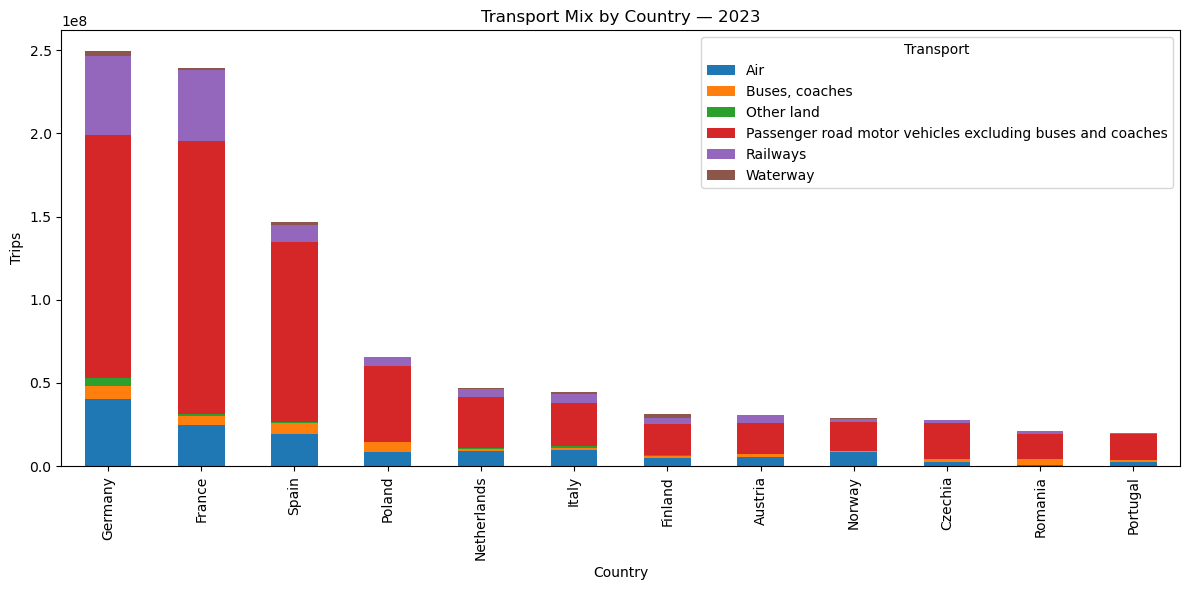

In [87]:
# 1) Transport mix by country — latest year (stacked bar)

latest = int(df_tttr2_full["Time"].max())

mix = (df_tttr2_full[df_tttr2_full["Time"] == latest]
       .groupby(["Country", "Transport"], as_index=False)["Value_transport"].sum()
       .pivot(index="Country", columns="Transport", values="Value_transport")
       .fillna(0))

top_n = 12
top_countries = mix.sum(axis=1).sort_values(ascending=False).head(top_n).index

ax = mix.loc[top_countries].plot(kind="bar", stacked=True, figsize=(12,6))
ax.set_title(f"Transport Mix by Country — {latest}")
ax.set_xlabel("Country"); ax.set_ylabel("Trips")
plt.tight_layout(); plt.show()

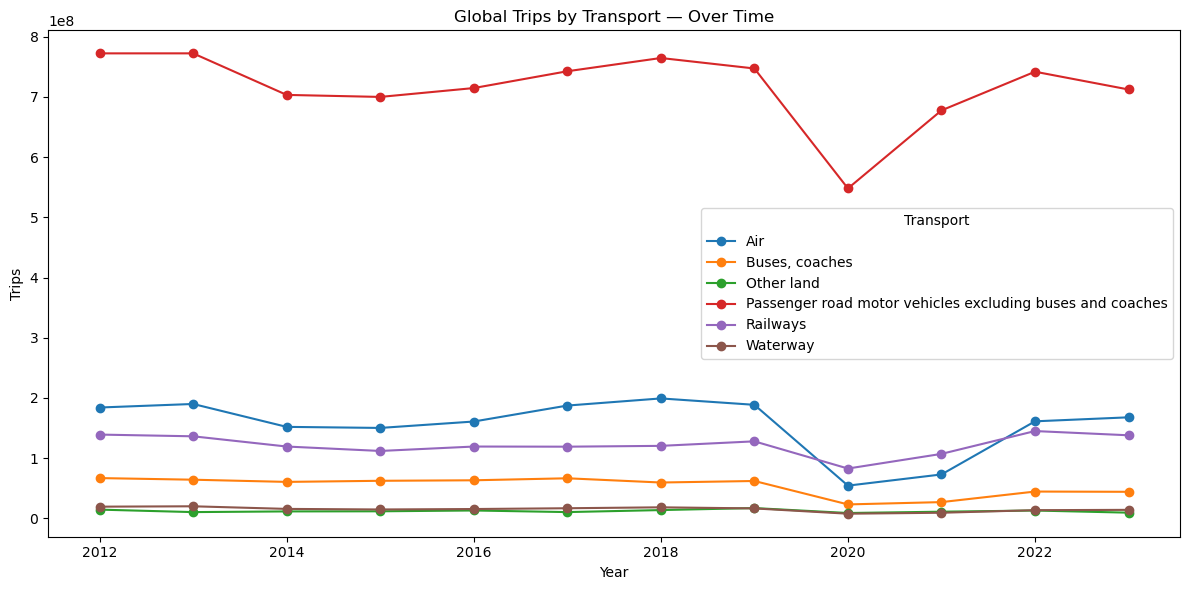

In [88]:
# 2) Global trends by transport — over time (line chart)

trend = (df_tttr2_full
         .groupby(["Time", "Transport"], as_index=False)["Value_transport"].sum()
         .pivot(index="Time", columns="Transport", values="Value_transport")
         .sort_index())

ax = trend.plot(figsize=(12,6), marker="o")
ax.set_title("Global Trips by Transport — Over Time")
ax.set_xlabel("Year"); ax.set_ylabel("Trips")
plt.tight_layout(); plt.show()

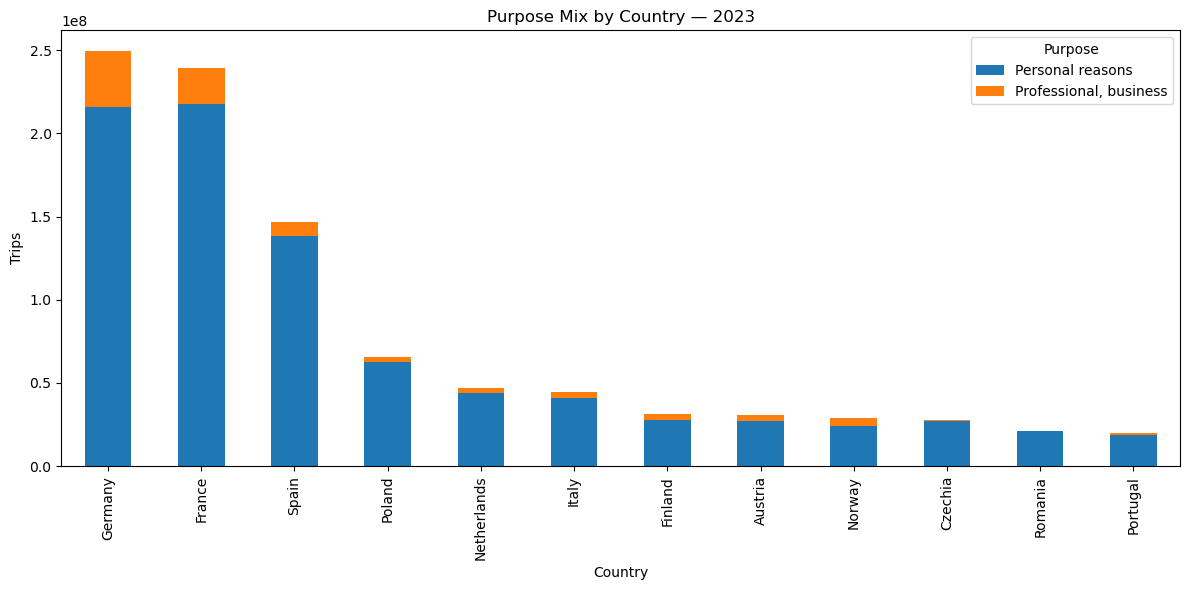

In [89]:
latest = int(df_tttr2_full["Time"].max())
mix_purpose = (df_tttr2_full[df_tttr2_full["Time"] == latest]
               .groupby(["Country","Purpose"], as_index=False)["Value_transport"].sum()
               .pivot(index="Country", columns="Purpose", values="Value_transport")
               .fillna(0))

top = mix_purpose.sum(axis=1).sort_values(ascending=False).head(12).index
ax = mix_purpose.loc[top].plot(kind="bar", stacked=True, figsize=(12,6))
ax.set_title(f"Purpose Mix by Country — {latest}")
ax.set_xlabel("Country"); ax.set_ylabel("Trips")
plt.tight_layout(); plt.show()

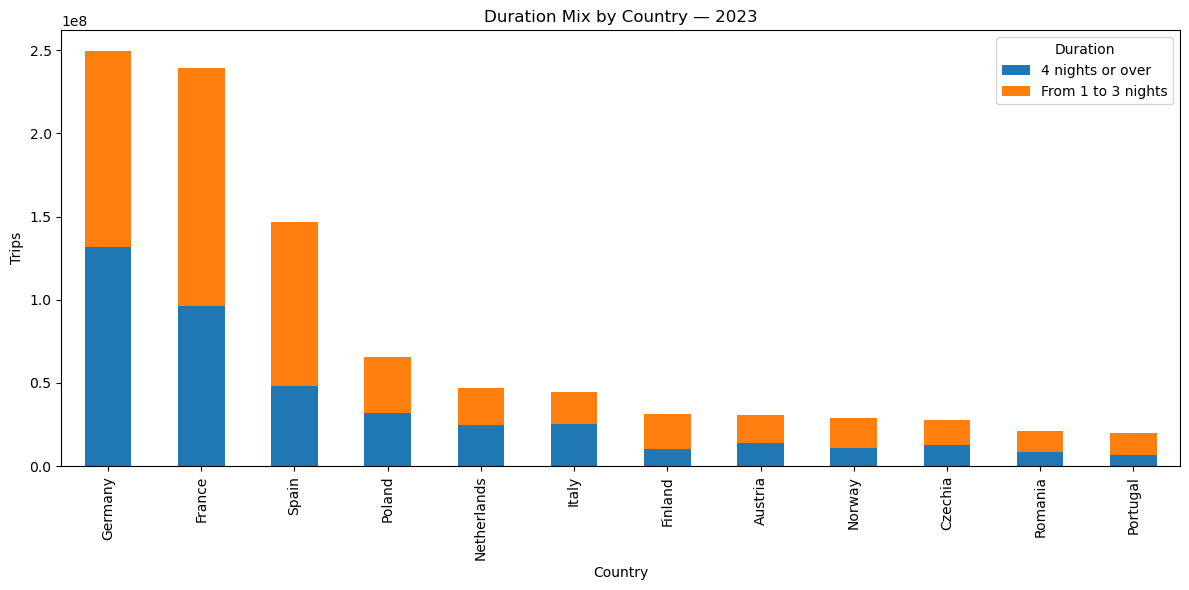

In [90]:
latest = int(df_tttr2_full["Time"].max())
mix_duration = (df_tttr2_full[df_tttr2_full["Time"] == latest]
                .groupby(["Country","Duration"], as_index=False)["Value_transport"].sum()
                .pivot(index="Country", columns="Duration", values="Value_transport")
                .fillna(0))

top = mix_duration.sum(axis=1).sort_values(ascending=False).head(12).index
ax = mix_duration.loc[top].plot(kind="bar", stacked=True, figsize=(12,6))
ax.set_title(f"Duration Mix by Country — {latest}")
ax.set_xlabel("Country"); ax.set_ylabel("Trips")
plt.tight_layout(); plt.show()

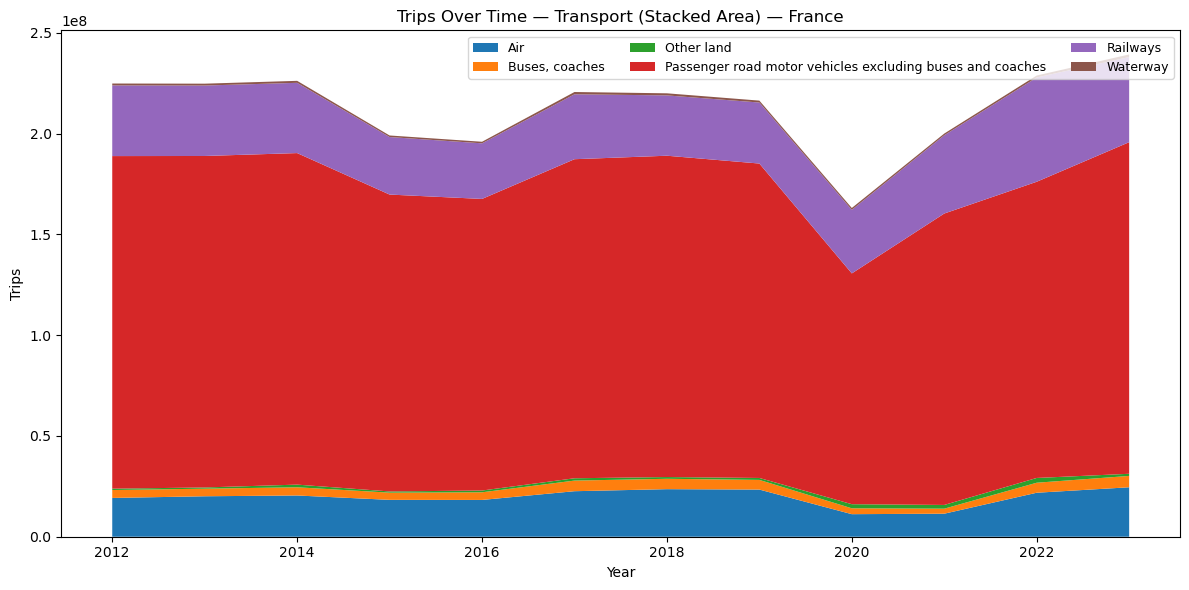

In [91]:
# 4) Stacked area over time — by Transport (filter by Purpose and/or Country)

purpose = None       # e.g., "Personal reasons" or None for all
country = "France"       # e.g., "Albania" or None for global

d = df_tttr2_full.copy()
if purpose is not None:
    d = d[d["Purpose"] == purpose]
if country is not None:
    d = d[d["Country"] == country]

trend = (d.groupby(["Time","Transport"], as_index=False)["Value_transport"].sum()
         .pivot(index="Time", columns="Transport", values="Value_transport")
         .sort_index().fillna(0))

fig, ax = plt.subplots(figsize=(12,6))
ax.stackplot(trend.index.astype(int), trend.T.values, labels=trend.columns)
ttl_parts = []
if country: ttl_parts.append(country)
if purpose: ttl_parts.append(purpose)
title = " • ".join(ttl_parts) if ttl_parts else "Global — All Purposes"
ax.set_title(f"Trips Over Time — Transport (Stacked Area) — {title}")
ax.set_xlabel("Year"); ax.set_ylabel("Trips")
ax.legend(ncols=3, fontsize=9)
plt.tight_layout(); plt.show()

## Part 3: tour_dem_ttw : Trips by Main Mode of transport

### 3-1- Eurostat data (tour_dem_ttw) - Cleaning

In [94]:
url_ttw = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/tour_dem_ttw?lang=EN"
r3 = requests.get(url_ttw, timeout=30)
r3.raise_for_status()
data3 = r3.json()

print("TTW Root keys:", list(data3.keys()))
print("TTW label:", data3.get("label"))
print("TTW updated:", data3.get("updated"))
print("TTW Dimensions (order):", data3.get("id"))
print("TTW Dimension sizes:", data3.get("size"))

TTW Root keys: ['version', 'class', 'label', 'source', 'updated', 'value', 'status', 'id', 'size', 'dimension', 'extension']
TTW label: Trips by detailed country/world region of main destination
TTW updated: 2025-02-27T23:00:00+0100
TTW Dimensions (order): ['freq', 'c_dest', 'purpose', 'duration', 'unit', 'geo', 'time']
TTW Dimension sizes: [1, 64, 4, 3, 1, 36, 12]


In [95]:
# 2) Decode sparse cube -> raw DataFrame (TTW)
dim_ids3 = data3["id"]
sizes3   = data3["size"]
dims3    = data3["dimension"]
values3  = data3["value"]  # dict: {flat_index: value}

# position -> code for each dimension
idx2code3 = {}
for d in dim_ids3:
    cat3 = dims3[d]["category"]
    idx_map3 = cat3.get("index")
    if isinstance(idx_map3, dict):
        idx2code3[d] = {idx: code for code, idx in idx_map3.items()}
    elif isinstance(idx_map3, list):
        idx2code3[d] = {i: code for i, code in enumerate(idx_map3)}
    else:
        raise ValueError(f"Dimension '{d}' has no usable 'index'.")

def unravel3(k, sizes3):
    k = int(k); pos3 = []
    for s in reversed(sizes3):
        pos3.append(k % s); k //= s
    return list(reversed(pos3))

rows3 = []
for flat_idx3, v3 in values3.items():
    pos3 = unravel3(flat_idx3, sizes3)
    row3 = {d: idx2code3[d][i3] for d, i3 in zip(dim_ids3, pos3)}
    row3["value"] = v3
    rows3.append(row3)

df_transport = pd.DataFrame(rows3)
print("df_transport shape:", df_raw_ttw3.shape)
print("df_transport columns:", df_raw_ttw3.columns.tolist())
display(df_transport.head())

df_transport shape: (95275, 8)
df_transport columns: ['freq', 'c_dest', 'purpose', 'duration', 'unit', 'geo', 'time', 'value']


,freq,c_dest,purpose,duration,unit,geo,time,value
0,A,AFR,PER,N1-3,NR,EA20,2012,284035
1,A,AFR,PER,N1-3,NR,EA20,2013,398118
2,A,AFR,PER,N1-3,NR,EA20,2014,355606
3,A,AFR,PER,N1-3,NR,EA20,2015,290213
4,A,AFR,PER,N1-3,NR,EA20,2016,270672


In [98]:
# 3) Map readable labels
geo_labels3     = dims3["geo"]["category"]["label"]
c_dest_labels3  = dims3["c_dest"]["category"]["label"]
purpose_labels3 = dims3["purpose"]["category"]["label"]
duration_labels3= dims3["duration"]["category"]["label"]

df_transport = pd.DataFrame({
    "Country":    df_transport["geo"].map(geo_labels3),
    "Destination":df_transport["c_dest"].map(c_dest_labels3),
    "Purpose":    df_transport["purpose"].map(purpose_labels3),
    "Duration":   df_transport["duration"].map(duration_labels3),
    "Time":       pd.to_numeric(df_transport["time"], errors="coerce").astype("Int64"),
    "Value_destination":  pd.to_numeric(df_transport["value"], errors="coerce")
    })

print("df_transport shape:", df_transport.shape)
display(df_transport.head())

df_transport shape: (95275, 6)


,Country,Destination,Purpose,Duration,Time,Value_destination
0,Euro area – 20 countries (from 2023),Africa,Personal reasons,From 1 to 3 nights,2012,284035
1,Euro area – 20 countries (from 2023),Africa,Personal reasons,From 1 to 3 nights,2013,398118
2,Euro area – 20 countries (from 2023),Africa,Personal reasons,From 1 to 3 nights,2014,355606
3,Euro area – 20 countries (from 2023),Africa,Personal reasons,From 1 to 3 nights,2015,290213
4,Euro area – 20 countries (from 2023),Africa,Personal reasons,From 1 to 3 nights,2016,270672


In [100]:
# 4) Clean Country (remove geo aggregates) + inspect Destination

# A) Remove geo aggregates in Country (same as before)
exclude_geo3 = {
    "European Union - 27 countries (from 2020)",
    "Euro area – 20 countries (from 2023)",
    "EFTA (European Free Trade Association countries)",
}
before = len(df_transport)
df_transport = df_transport[~df_transport["Country"].isin(exclude_geo3)].reset_index(drop=True)
after = len(df_transport)
print(f"Removed {before - after} rows based on Country aggregates. New shape: {df_transport.shape}")

# B) See what's in Destination (labels)
dest_labels = sorted(df_transport["Destination"].dropna().unique())
print(f"\nUnique Destination labels ({len(dest_labels)}):")
for d in dest_labels:
    print(" -", d)

Removed 15751 rows based on Country aggregates. New shape: (79524, 6)

Unique Destination labels (63):
 - Africa
 - All countries of the world
 - America
 - Argentina
 - Asia
 - Australia
 - Austria
 - Belgium
 - Brazil
 - Bulgaria
 - Canada
 - Central and South America
 - China
 - Croatia
 - Cyprus
 - Czechia
 - Denmark
 - Domestic country
 - EU27 countries (from 2020) except reporting country
 - Estonia
 - Europe
 - European Free Trade Association
 - European Union - 27 countries (from 2020)
 - European Union - 28 countries (2013-2020)
 - Finland
 - Foreign country
 - France
 - Germany
 - Greece
 - Hungary
 - Iceland
 - Ireland
 - Italy
 - Japan
 - Latvia
 - Lithuania
 - Luxembourg
 - Malta
 - Netherlands
 - Non-EU27 countries (from 2020) nor reporting country
 - Northern America
 - Norway
 - Oceania
 - Other African countries (aggregate changing according to the context)
 - Other Asian countries (aggregate changing according to the context)
 - Other Central or South American countri

In [102]:
def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("\u2013", "-").replace("\u2011", "-")  # en-dash & no-break hyphen -> hyphen
    return s.strip().casefold()

# 1) Labels des PAYS à partir de la dimension c_dest (codes de 2 lettres)
c_dest_labels = dims3["c_dest"]["category"]["label"]  # {code: label}
country_labels = {lbl for code, lbl in c_dest_labels.items() if isinstance(code, str) and len(code) == 2}

# 2) Normalisation des labels (pour matcher sans surprise)
country_labels_norm = {_norm(lbl) for lbl in country_labels}

# 3) Filtre df_lab_ttw3 sur Destination ∈ pays (après normalisation)
before = len(df_transport)
mask_country_dest = df_transport["Destination"].map(_norm).isin(country_labels_norm)
df_transport = df_transport[mask_country_dest].reset_index(drop=True)
after = len(df_transport)

print(f"Kept only COUNTRY destinations (by c_dest labels): {after} rows (removed {before - after}).")
print("Unique Destination countries:", df_transport['Destination'].nunique())
display(df_transport.head())

Kept only COUNTRY destinations (by c_dest labels): 37851 rows (removed 41673).
Unique Destination countries: 43


,Country,Destination,Purpose,Duration,Time,Value_destination
0,Spain,Argentina,Personal reasons,1 night or over,2012,55876
1,Spain,Argentina,Personal reasons,1 night or over,2013,64694
2,Spain,Argentina,Personal reasons,1 night or over,2014,46423
3,Spain,Argentina,Personal reasons,1 night or over,2015,70450
4,Spain,Argentina,Personal reasons,1 night or over,2016,76615


In [104]:
def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    return s.replace("\u2013", "-").replace("\u2011", "-").strip().casefold()

# Pays = codes c_dest à 2 lettres -> on récupère leurs libellés
c_dest_labels = dims3["c_dest"]["category"]["label"]  # {code: label}
country_labels = {lbl for code, lbl in c_dest_labels.items() if isinstance(code, str) and len(code) == 2}
country_labels_norm = {_norm(lbl) for lbl in country_labels}

# Filtrer df_lab_ttw3 sur les pays (en comparant par libellé normalisé)
before = len(df_transport)
mask_countries = df_transport["Destination"].map(_norm).isin(country_labels_norm)
df_transport = df_transport.loc[mask_countries].reset_index(drop=True)
after = len(df_transport)

print(f"Kept only COUNTRY destinations: {after} rows (removed {before - after}).")
display(df_transport.head())

Kept only COUNTRY destinations: 37851 rows (removed 0).


,Country,Destination,Purpose,Duration,Time,Value_destination
0,Spain,Argentina,Personal reasons,1 night or over,2012,55876
1,Spain,Argentina,Personal reasons,1 night or over,2013,64694
2,Spain,Argentina,Personal reasons,1 night or over,2014,46423
3,Spain,Argentina,Personal reasons,1 night or over,2015,70450
4,Spain,Argentina,Personal reasons,1 night or over,2016,76615


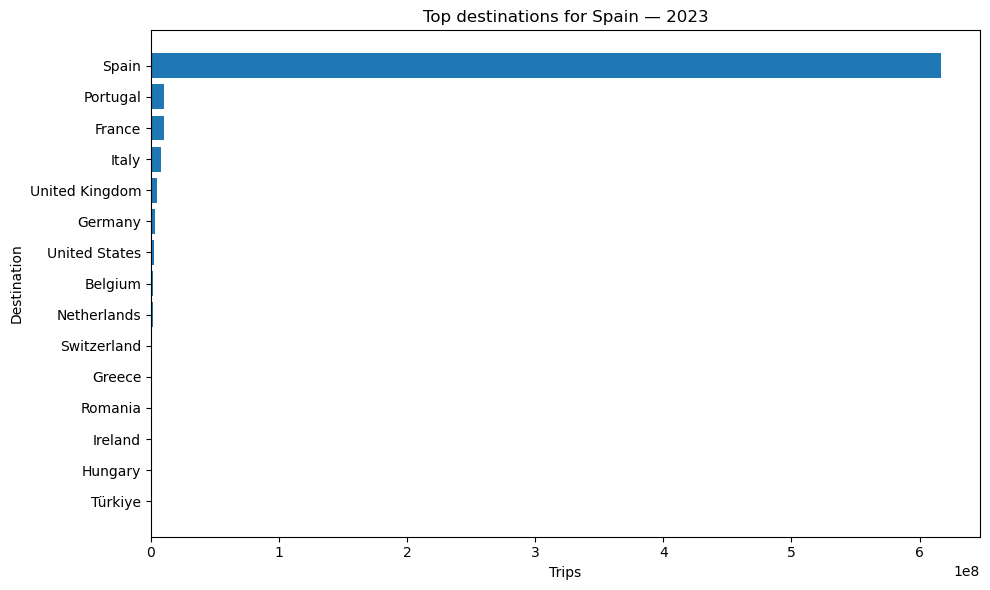

In [106]:
origin = "Spain"  # <- change si besoin
year   = int(df_transport["Time"].max())

top_dest = (df_transport[(df_transport["Country"] == origin) & (df_transport["Time"] == year)]
            .groupby("Destination", as_index=False)["Value_destination"].sum()
            .sort_values("Value_destination", ascending=False)
            .head(15))

plt.figure(figsize=(10,6))
plt.barh(top_dest["Destination"], top_dest["Value_destination"])
plt.gca().invert_yaxis()
plt.title(f"Top destinations for {origin} — {year}")
plt.xlabel("Trips"); plt.ylabel("Destination")
plt.tight_layout(); plt.show()

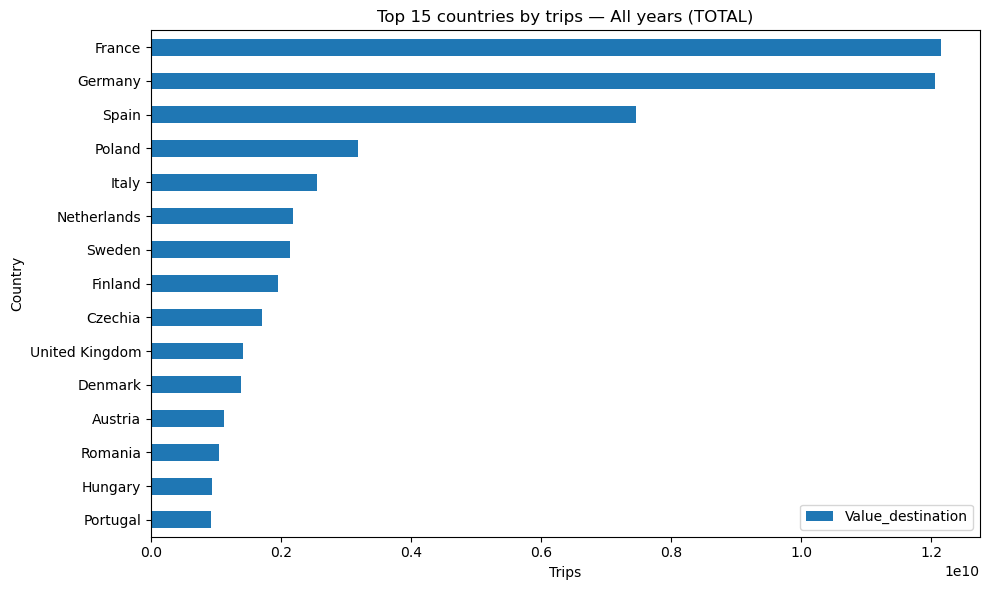

In [108]:
# Top countries by TOTAL trips across all years

top_n = 15
top_total = (df_transport
             .groupby("Country", as_index=False)["Value_destination"].sum()
             .sort_values("Value_destination", ascending=False)
             .head(top_n))

ax = top_total.plot(kind="barh", x="Country", y="Value_destination", figsize=(10,6))
ax.invert_yaxis()
ax.set_title(f"Top {top_n} countries by trips — All years (TOTAL)")
ax.set_xlabel("Trips"); ax.set_ylabel("Country")
plt.tight_layout(); plt.show()

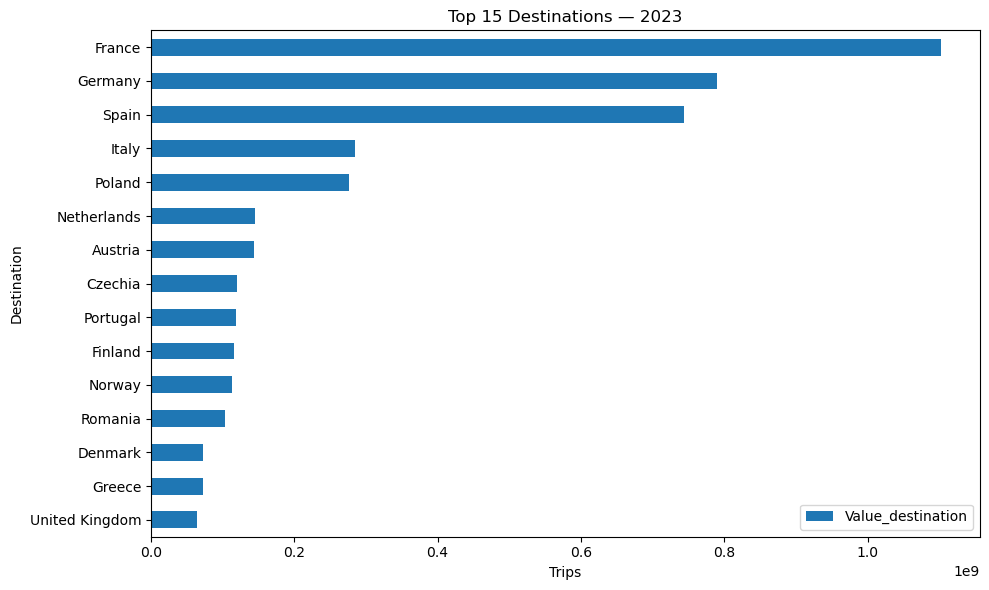

In [110]:
# TOP destinations (global) — dernière année

latest = int(df_transport["Time"].max())
top_n = 15

top_dest_latest = (df_transport[df_transport["Time"] == latest]
                   .groupby("Destination", as_index=False)["Value_destination"].sum()
                   .sort_values("Value_destination", ascending=False)
                   .head(top_n))

ax = top_dest_latest.plot(kind="barh", x="Destination", y="Value_destination", figsize=(10,6))
ax.invert_yaxis()
ax.set_title(f"Top {top_n} Destinations — {latest}")
ax.set_xlabel("Trips"); ax.set_ylabel("Destination")
plt.tight_layout(); plt.show()

In [114]:
# --- 0) Schéma final (union) ---
COLS = [
    "Country", "Time",
    "Accommodation", "Purpose", "Duration", "Transport", "Destination",
    "Value_accomodation", "Value_transport", "Value_destination",
]

def _standardize(df, mapping_candidates, label):
    """
    - mapping_candidates: {target_col: [candidate1, candidate2, ...]}
    - Renomme la 1ère colonne existante trouvée pour chaque 'target_col'
    - Retourne un DF avec toutes les colonnes de COLS (reindex), sans KeyError
    """
    df = df.copy()
    rename_map = {}
    for target, cands in mapping_candidates.items():
        if target in df.columns:
            continue
        for c in cands:
            if c in df.columns:
                rename_map[c] = target
                break
    if rename_map:
        print(f"[{label}] Renamed columns:", rename_map)
        df = df.rename(columns=rename_map)

    # Reindex pour avoir l'union des colonnes (manquantes -> NaN)
    df_std = df.reindex(columns=COLS)
    return df_std

# --- 1) TTAC ---
# On s'attend à Country, Accommodation, Time, Value_accomodation
ttac_map = {
    "Country": ["country", "Country"],
    "Accommodation": ["accommodation", "Accommodation", "accommod", "accommod_label"],
    "Time": ["time", "Time", "year", "Year"],
    "Value_accomodation": ["Value_accomodation", "value", "Value", "Value_accommodation"],
}
ttac_u = _standardize(df_transport, ttac_map, label="TTAC")

# --- 2) TTTR ---
# On s'attend à Country, Time, Purpose, Duration, Transport, Value_transport
tttr_map = {
    "Country": ["country", "Country"],
    "Time": ["time", "Time", "year", "Year"],
    "Purpose": ["Purpose", "purpose"],
    "Duration": ["Duration", "duration"],
    "Transport": ["Transport", "tra_mode", "transport"],
    "Value_transport": ["Value_transport", "value", "Value"],
}
tttr_u = _standardize(df_tttr2_full, tttr_map, label="TTTR")

# --- 3) TTW ---
# On s'attend à Country, Destination, Purpose, Duration, Time, Value_destination
ttw_map = {
    "Country": ["country", "Country"],
    "Destination": ["Destination", "destination", "c_dest"],
    "Purpose": ["Purpose", "purpose"],
    "Duration": ["Duration", "duration"],
    "Time": ["time", "Time", "year", "Year"],
    "Value_destination": ["Value_destination", "value", "Value"],
}
ttw_u = _standardize(df_transport, ttw_map, label="TTW")

# --- 4) Concat final + types propres ---
df_all = pd.concat([ttac_u, tttr_u, ttw_u], ignore_index=True)

df_all["Time"] = pd.to_numeric(df_all["Time"], errors="coerce").astype("Int64")
for v in ["Value_accomodation", "Value_transport", "Value_destination"]:
    if v in df_all.columns:
        df_all[v] = pd.to_numeric(df_all[v], errors="coerce")

print("df_all shape:", df_all.shape)
print(df_all.dtypes)
display(df_all.head(12))

df_all shape: (81025, 10)
Country                object
Time                    Int64
Accommodation         float64
Purpose                object
Duration               object
Transport              object
Destination            object
Value_accomodation    float64
Value_transport       float64
Value_destination     float64
dtype: object


,Country,Time,Accommodation,Purpose,Duration,Transport,Destination,Value_accomodation,Value_transport,Value_destination
0,Spain,2012,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,55876.0
1,Spain,2013,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,64694.0
2,Spain,2014,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,46423.0
3,Spain,2015,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,70450.0
4,Spain,2016,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,76615.0
5,Spain,2017,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,61424.0
6,Spain,2018,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,52242.0
7,Spain,2019,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,48836.0
8,Spain,2022,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,67553.0
9,Spain,2023,NaN,Personal reasons,1 night or over,NaN,Argentina,NaN,NaN,83050.0


In [122]:
df_all["Accommodation"] = df_all["Accommodation"].astype("object")

In [124]:
print(df_all.dtypes)

Country                object
Time                    Int64
Accommodation          object
Purpose                object
Duration               object
Transport              object
Destination            object
Value_accomodation    float64
Value_transport       float64
Value_destination     float64
dtype: object


In [ ]:
# df_all.to_csv("../data/clean/eurostat_trips_all.csv", index=False, encoding="utf-8")